In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt

#Loading Data
train_data = pd.read_csv('../DATA/data.csv')

In [2]:
train_data.head()

,ArticleId,Text,Category
0,14,One man's claims that he scammed people on the...,TECH
1,18,Maury Wills who helped the Los Angeles Dodgers...,SPORTS
2,21,For the past 18 months Hollywood has effective...,ENTERTAINMENT
3,22,President issues vow as tensions with China rise.,POLITICS
4,25,An annual celebration took on a different feel...,POLITICS


In [3]:
# DataFrame Values
print("Number of Rows : ",train_data.shape[0])
print("Number of Columns : ",train_data.shape[1])
print("Column Names : ",train_data.columns.values)

Number of Rows :  64351
Number of Columns :  3
Column Names :  ['ArticleId' 'Text' 'Category']


In [4]:
# Data Points per Category
train_data['Category'].value_counts()

POLITICS         34696
ENTERTAINMENT    16953
BUSINESS          5753
SPORTS            4933
TECH              1958
Name: Category, dtype: int64

In [5]:
# Removing rows with missing values
train_data.dropna(inplace=True)
train_data.isna().sum()

ArticleId    0
Text         0
Category     0
dtype: int64

In [6]:
target_category = train_data['Category'].unique()
print(target_category)

['TECH' 'SPORTS' 'ENTERTAINMENT' 'POLITICS' 'BUSINESS']


<AxesSubplot:xlabel='News Categories', ylabel='Data Points Per Category'>

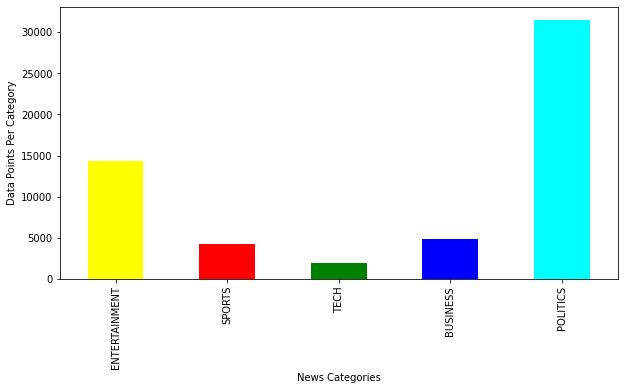

In [7]:
# Plotting data points per category
news_cat = train_data['Category'].value_counts()
my_colors = ['yellow', 'red', 'green', 'blue', 'cyan', 'magenta']
news_cat.sample(frac=1).plot(kind='bar', figsize=(10,5), xlabel="News Categories", ylabel="Data Points Per Category", color=my_colors)

In [8]:
import nltk
from nltk.corpus import stopwords

print(len(stopwords.words('english')))
print(stopwords.words('english'))

179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than

In [9]:
import warnings
import re

stop_words = set(stopwords.words('english'))

def txt_preprocessing(total_text, index, column, df):
    if type(total_text) is not int:
        string = ""
        total_text = re.sub('[^a-zA-Z0-9\n]', ' ', total_text)
        total_text = re.sub('\s+',' ', total_text)
        total_text = total_text.lower()
        
        for word in total_text.split():
            if not word in stop_words:
                string += word + " "
        df[column][index] = string

In [10]:
# Preprocessing the data

for index, row in train_data.iterrows():
    if type(row['Text']) is str:
        txt_preprocessing(row['Text'], index, 'Text', train_data)

train_data.head()

,ArticleId,Text,Category
0,14,one man claims scammed people platform caused ...,TECH
1,18,maury wills helped los angeles dodgers win thr...,SPORTS
2,21,past 18 months hollywood effectively boycotted...,ENTERTAINMENT
3,22,president issues vow tensions china rise,POLITICS
4,25,annual celebration took different feel russia ...,POLITICS


In [11]:
# Dividing the data into train and test set
from sklearn.model_selection import train_test_split
X_train = train_data
y_train = train_data['Category']

X_train, X_test, y_train, y_test = train_test_split(X_train, y_train, test_size=0.20)

print("NUMBER OF DATA POINTS IN TRAIN DATA :", X_train.shape[0])
print("NUMBER OF DATA POINTS IN TEST DATA  :", X_test.shape[0])

NUMBER OF DATA POINTS IN TRAIN DATA : 45578
NUMBER OF DATA POINTS IN TEST DATA  : 11395


In [13]:
from sklearn.feature_extraction.text import CountVectorizer

text_vectorizer = CountVectorizer()
train_text_encoded = text_vectorizer.fit_transform(X_train['Text'])

train_text_features = text_vectorizer.get_feature_names_out()
train_text_feature_counts = train_text_encoded.sum(axis=0).A1
text_feature_dict = dict(zip(list(train_text_features),train_text_feature_counts))

print("Total Number of Unique Words in Train Data :",len(train_text_features))

Total Number of Unique Words in Train Data : 36767


In [20]:
print(len(text_feature_dict))
for word, frequency in list(text_feature_dict.items()):
    if word[0] >= '0' and word[0] <= '9':
        del text_feature_dict[word]

print(len(text_feature_dict))

34505
34505


In [21]:
from sklearn.preprocessing import normalize

train_text_encoded = normalize(train_text_encoded, axis=0)
test_text_encoded = text_vectorizer.transform(X_test['Text'])
test_text_encoded = normalize(test_text_encoded, axis=0)

In [22]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

alpha = [0.00001, 0.0001, 0.001, 0.1, 1, 10, 100, 1000]

cv_log_error_array = []

for i in alpha:
    clf = MultinomialNB(alpha=i)
    clf.fit(train_text_encoded, y_train)
    
    nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
    nb_sig_clf.fit(train_text_encoded, y_train)
    
    sig_clf_probs = nb_sig_clf.predict_proba(test_text_encoded)
    
    cv_log_error_array.append(log_loss(y_test, sig_clf_probs, labels=clf.classes_, eps=1e-15))

best_alpha = np.argmin(cv_log_error_array)

clf = MultinomialNB(alpha=alpha[best_alpha])
clf.fit(train_text_encoded, y_train)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_encoded, y_train)

predict_y = nb_sig_clf.predict_proba(train_text_encoded)
print('For values of best alpha =', alpha[best_alpha],"The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-6))

predict_y = nb_sig_clf.predict_proba(test_text_encoded)
print('For values of best alpha =', alpha[best_alpha], "The cross validation log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-6))

For values of best alpha = 0.1 The train log loss is: 0.5846027830046615
For values of best alpha = 0.1 The cross validation log loss is: 0.8414588866647739


In [24]:
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import log_loss

clf = MultinomialNB(alpha=0.1)
clf.fit(train_text_encoded, y_train)

nb_sig_clf = CalibratedClassifierCV(clf, method="sigmoid")
nb_sig_clf.fit(train_text_encoded, y_train)

predict_y = nb_sig_clf.predict_proba(train_text_encoded)
print("The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-6))

predict_y = nb_sig_clf.predict_proba(test_text_encoded)
print("The cross validation log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-6))

The train log loss is: 0.5846027830046615
The cross validation log loss is: 0.8414588866647739


In [25]:
from sklearn.metrics import accuracy_score
predicted_y = nb_sig_clf.predict(test_text_encoded)
train_accuracy = (nb_sig_clf.score(train_text_encoded, y_train)*100)
cv_accuracy = (accuracy_score(predicted_y, y_test)*100)

print("Naive Bayes Train Accuracy -",train_accuracy)
print("Naive Bayes CV Accuracy -",cv_accuracy)

Naive Bayes Train Accuracy - 81.94304269603757
Naive Bayes CV Accuracy - 70.27643703378675
